## Notebooks for workload prediction tests
### Using different sklearn libraries

Bytte till notebooks för de kändes lättare...

This is just for prediction tests!!

In [287]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression  
from sklearn.kernel_approximation import RBFSampler

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import svm
from numpy import mean
from numpy import std
from scipy.fft import fft

In [288]:
##Access Target_device data
QuerytoolBASE = "http://127.0.0.1:5000/"
response = requests.get(QuerytoolBASE+"databaseservice",json={"autoscaler": "1998-05-02"})
data_result = response.json()


### Preprocess 

                     total_load
timestamp                      
1998-05-02 00:00:00       31969
1998-05-02 01:00:00       31132
1998-05-02 02:00:00       27349
1998-05-02 03:00:00       29052
1998-05-02 04:00:00       28462
...                         ...
1998-05-23 19:00:00      127124
1998-05-23 20:00:00      124229
1998-05-23 21:00:00      116394
1998-05-23 22:00:00      102141
1998-05-23 23:00:00       99149

[528 rows x 1 columns]


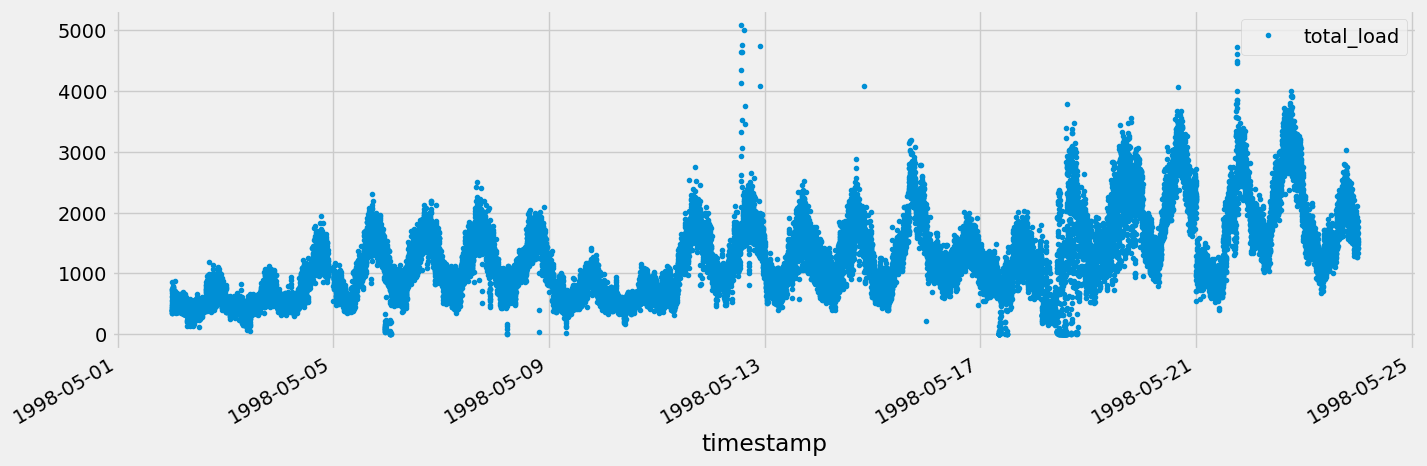

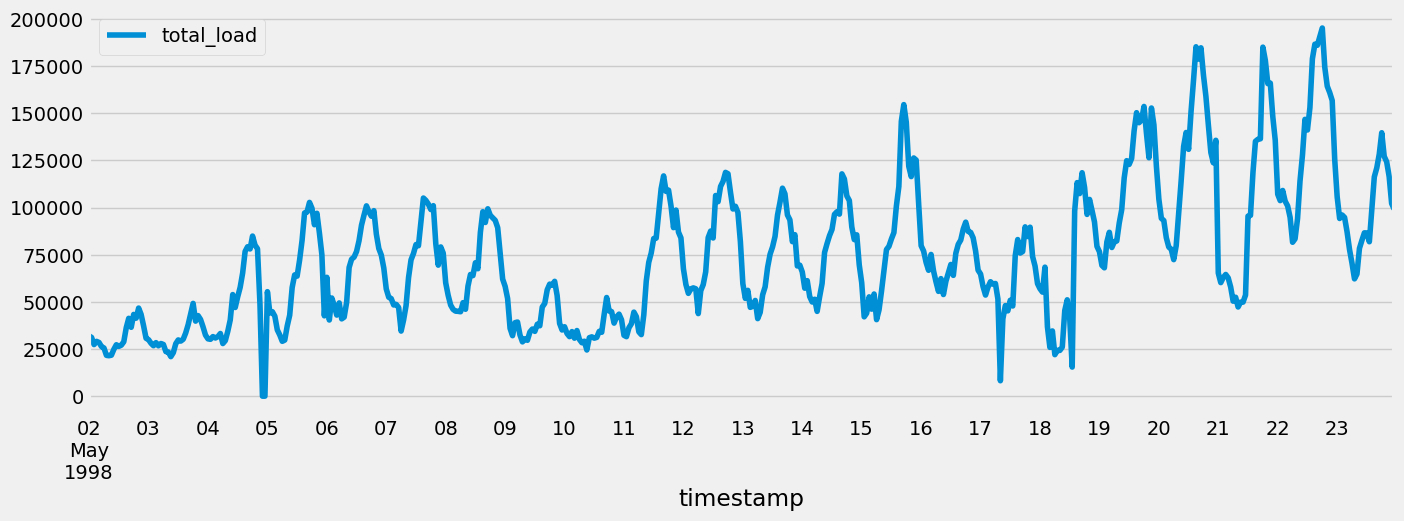

In [286]:
historical_df = pd.DataFrame(data_result, columns=['timestamp', 'average_load', 'total_load', 'instances'])
historical_df['timestamp'] = pd.to_datetime(historical_df['timestamp']) 
historical_df['total_load'] = historical_df['total_load'].astype(int)
historical_df = historical_df[ historical_df['total_load']<6000] 
historical_df = historical_df.set_index("timestamp")
historical_df =historical_df.drop(columns=[ 'average_load', 'instances'])
historical_df.plot(style=".",figsize=(15,5))
historical_df.head()
# Resample the data per hour, round to nearest hour, and sum the total_load
hourly_sum = historical_df.resample('H').sum()
hourly_sum.plot(figsize=(15,5))
print(hourly_sum)

### Train/ Test Split

In [224]:
#Importing libs from tutorial
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

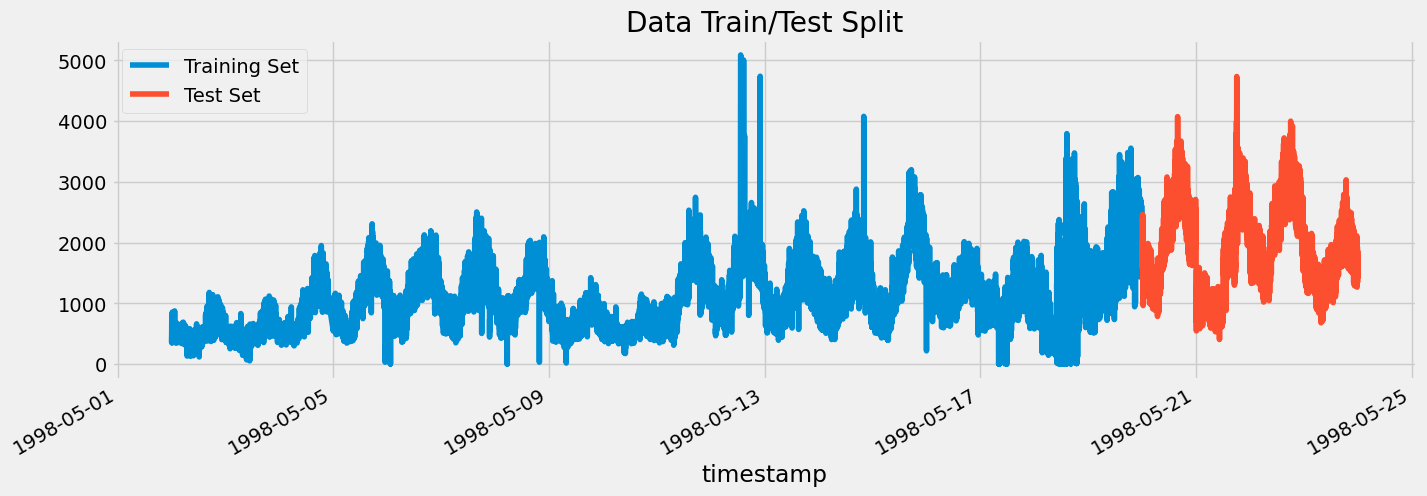

In [225]:
train = historical_df.loc[historical_df.index < "1998-05-20 00:00:00"]
test = historical_df.loc[historical_df.index >= "1998-05-20 00:00:00"]
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

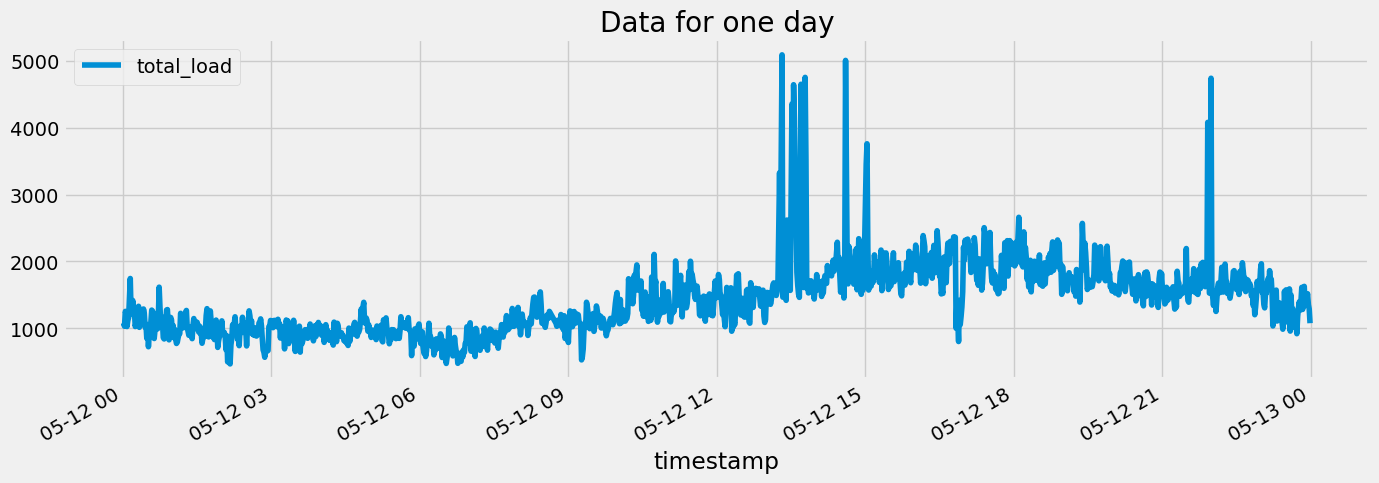

In [226]:
historical_df.loc[(historical_df.index > '1998-05-12 00:00:00') & (historical_df.index < '1998-05-13 00:00:00')] \
    .plot(figsize=(15, 5), title='Data for one day')
plt.show()

In [227]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
   #df['minute'] = df.index.minute NOT NECESSARY
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = create_features(historical_df)

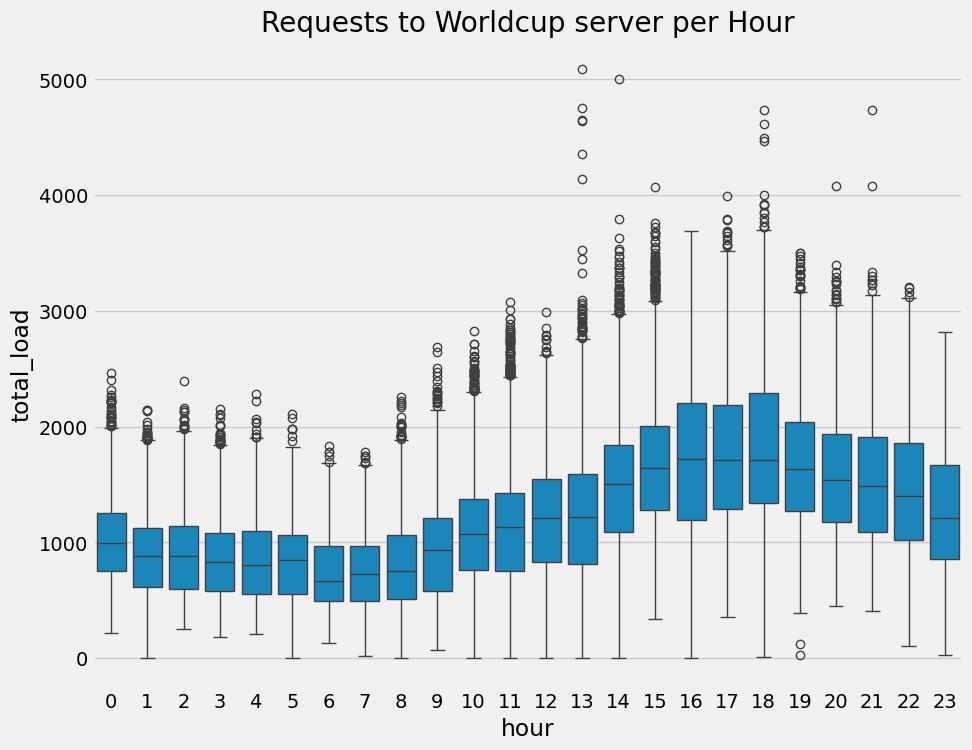

In [228]:
# Visualize

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='total_load')
ax.set_title('Requests to Worldcup server per Hour')
plt.show()

In [229]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek']
TARGET = 'total_load'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [230]:
reg = xgb.XGBRegressor(n_estimators = 2000, early_stopping_rounds = 50,learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:550.43292	validation_1-rmse:1086.69869


[100]	validation_0-rmse:381.45519	validation_1-rmse:955.06674
[200]	validation_0-rmse:350.54486	validation_1-rmse:920.59483
[300]	validation_0-rmse:345.18998	validation_1-rmse:912.03962
[400]	validation_0-rmse:344.06024	validation_1-rmse:910.86650
[455]	validation_0-rmse:343.83635	validation_1-rmse:911.04246


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature importances

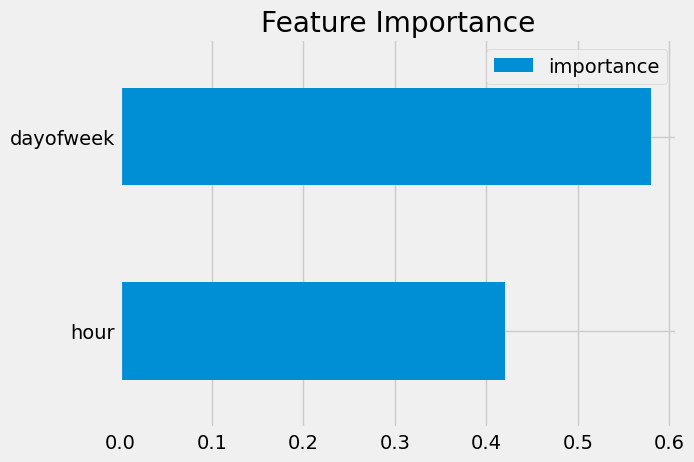

In [188]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

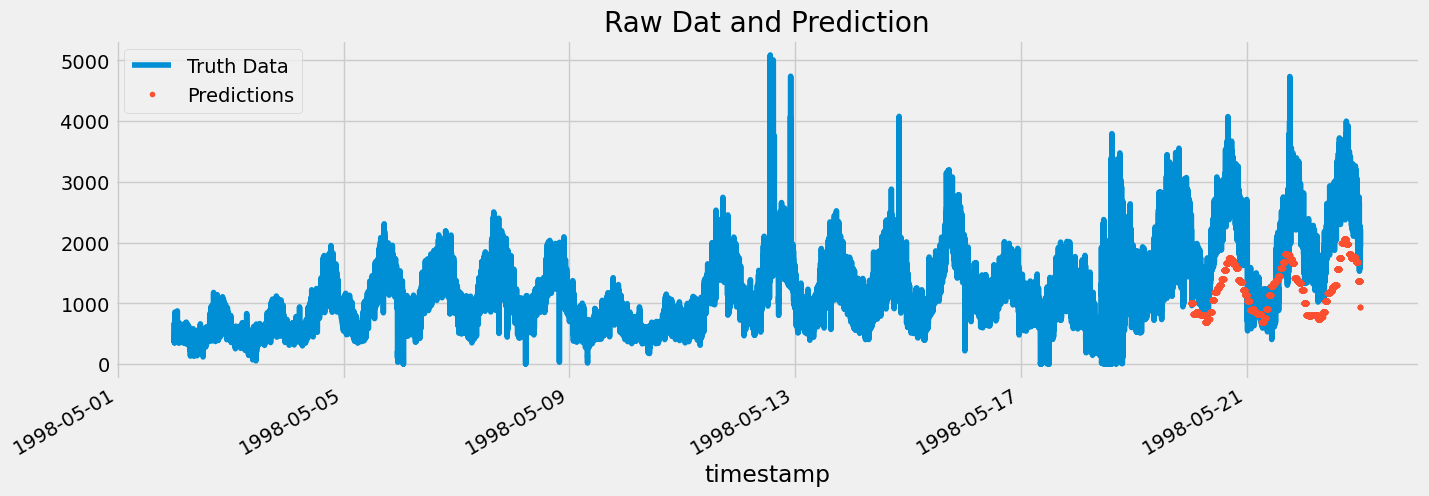

In [189]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_load']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


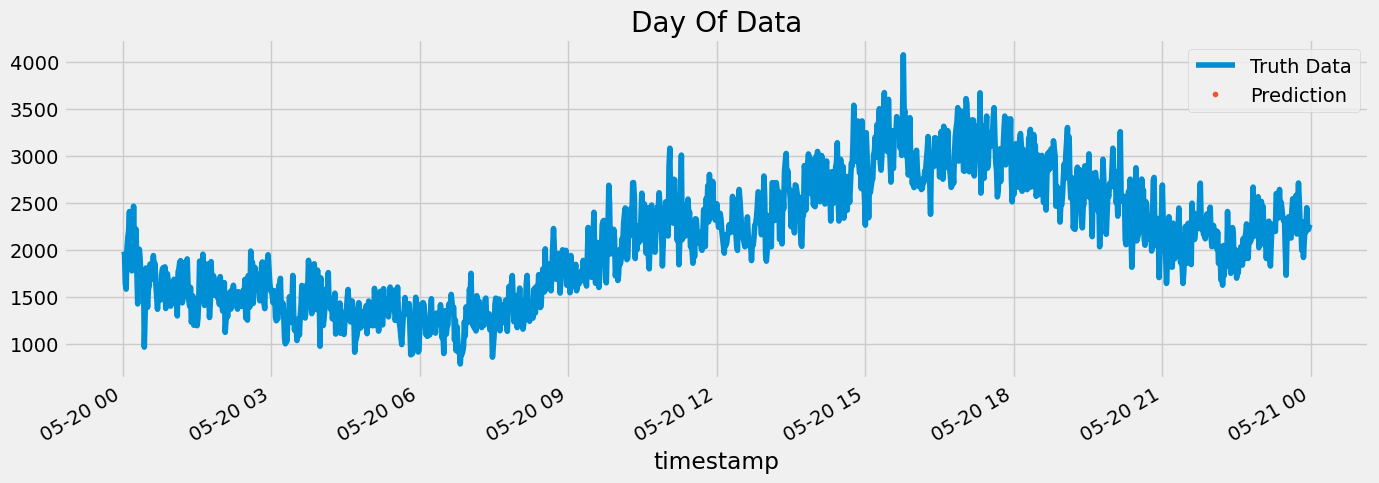

In [190]:
ax = df.loc[(df.index > '1998-05-20 00:00:00') & (df.index < '1998-05-21 00:00:00')]['total_load'] \
    .plot(figsize=(15, 5), title='Day Of Data')
df.loc[(df.index > '1998-05-18 00:00:00') & (df.index < '1998-05-19 00:00:00')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()


In [231]:
###För att kika vilka dagar som var sämst predictade

score = np.sqrt(mean_squared_error(test['total_load'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

KeyError: 'prediction'

### Skapa framtida prediktion!

In [232]:
from datetime import timedelta
last_date = historical_df.index.max().replace(hour=0, minute=0, second=0)
next_five_days_dates = pd.date_range(start=last_date+timedelta(days=1), end=last_date +timedelta(days=16), freq='T')


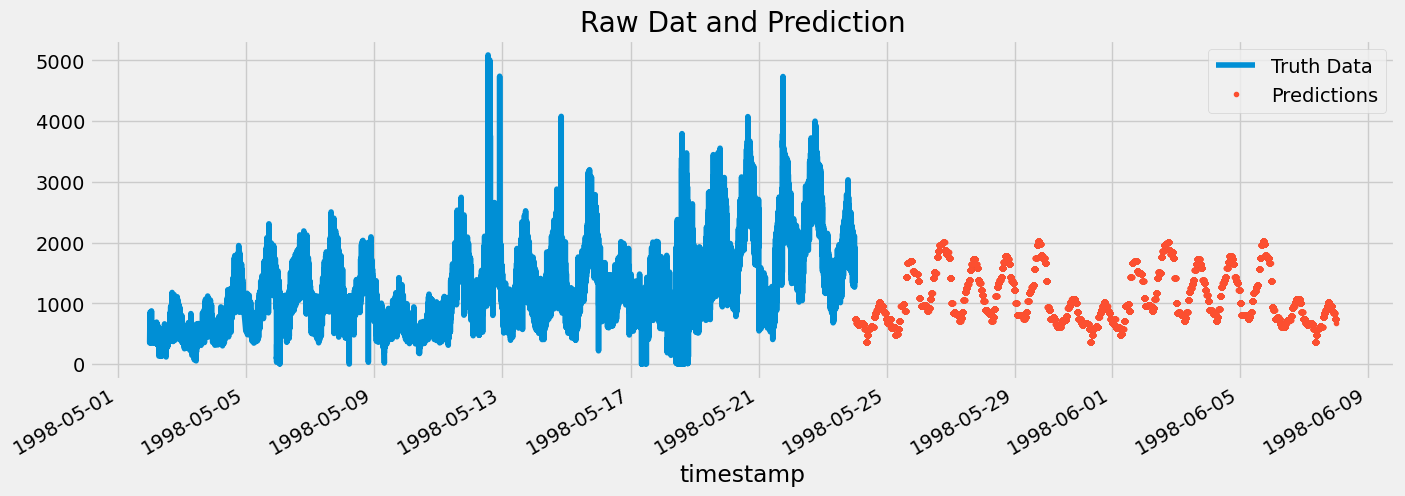

In [233]:
next_days_df = pd.DataFrame(next_five_days_dates, columns=["timestamp"])
next_days_df = next_days_df.set_index("timestamp")
next_day_test = create_features(next_days_df)
next_days_df['prediction'] = reg.predict(next_day_test)
#df = df.merge(next_days_df[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_load']].plot(figsize=(15, 5))
next_days_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

## Time series Cross Validation

In [234]:
from sklearn.model_selection import TimeSeriesSplit

In [235]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 60*24, gap=24) #hour/dayofweek
df = df.sort_index()

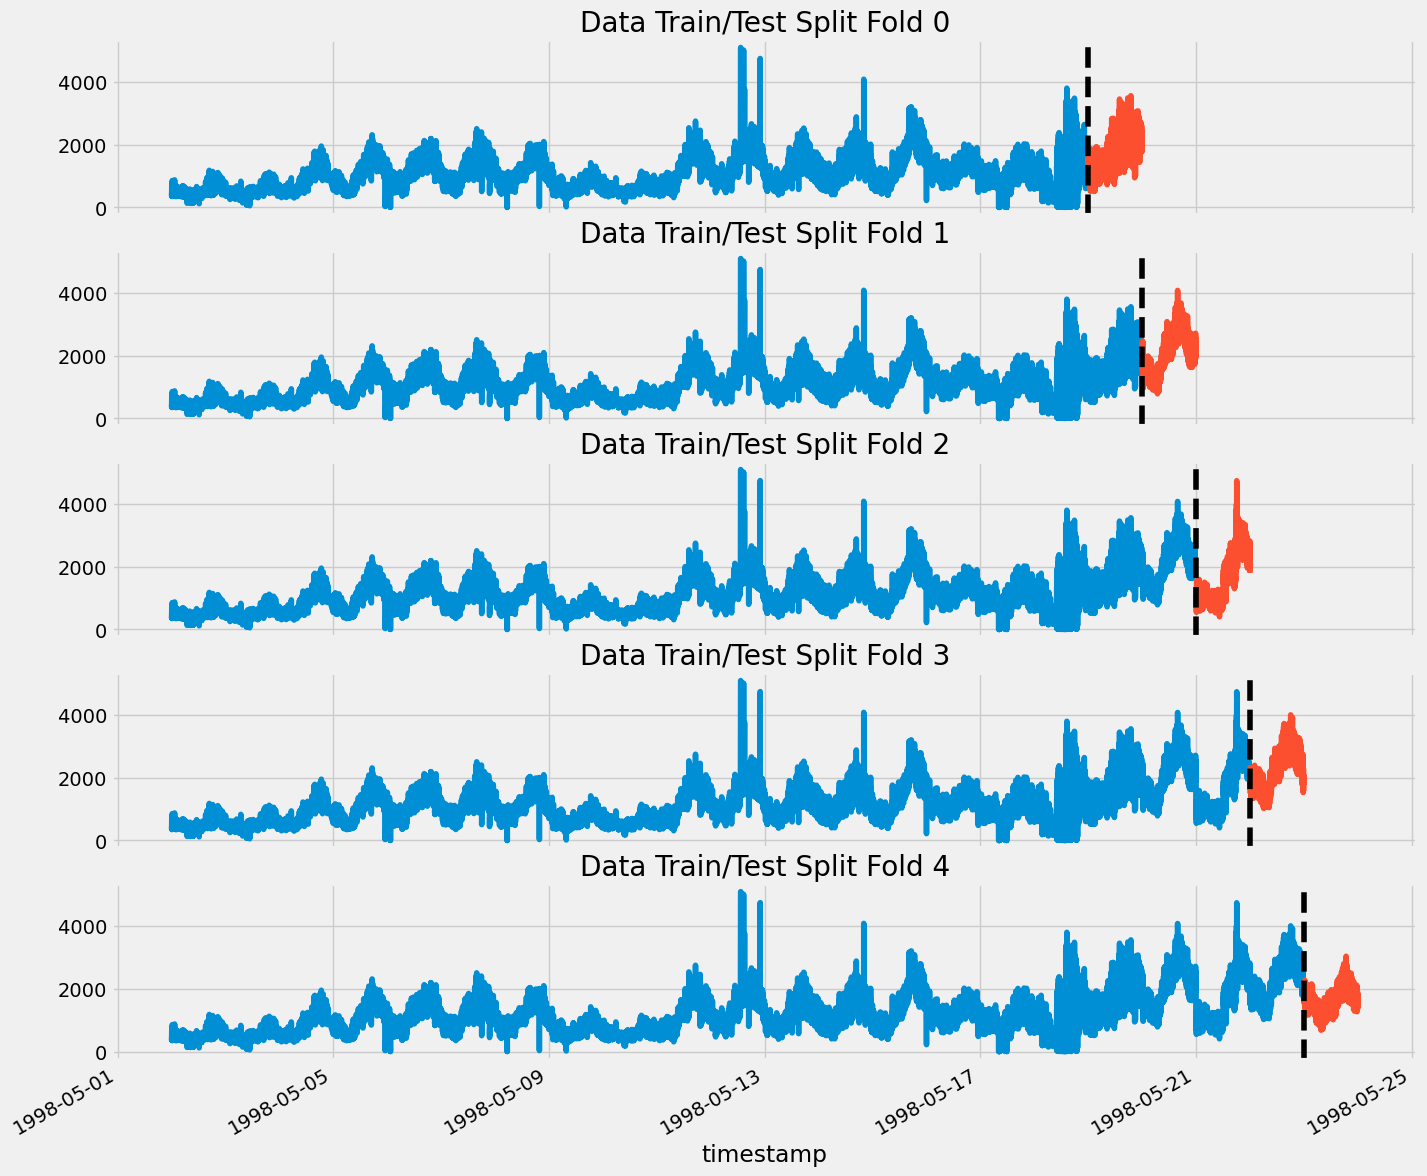

In [236]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['total_load'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['total_load'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Lag filters

Look back in to the past, use the target value for that many days in the past. What was the trarget(x) in the past?

In [237]:
def add_lags(df):
    target_map = df['total_load'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df
df = add_lags(df)
df.tail()

,total_load,hour,dayofweek,lag1,lag2,lag3
timestamp,,,,,,
1998-05-23 23:55:00,1567,23,5,1095.0,533.0,423.0
1998-05-23 23:56:00,1763,23,5,985.0,466.0,475.0
1998-05-23 23:57:00,1656,23,5,957.0,471.0,464.0
1998-05-23 23:58:00,1475,23,5,1252.0,429.0,432.0
1998-05-23 23:59:00,1342,23,5,987.0,487.0,435.0


Train using the CV and the lag filters

In [260]:
tss = TimeSeriesSplit(n_splits=10, test_size=60*24, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek',
                'lag1','lag2','lag3']
    TARGET = 'total_load'
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:1062.60101	validation_1-rmse:1373.13586


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:447.57520	validation_1-rmse:622.44314
[200]	validation_0-rmse:263.91664	validation_1-rmse:391.85007
[300]	validation_0-rmse:218.38955	validation_1-rmse:321.47614
[400]	validation_0-rmse:206.06712	validation_1-rmse:298.08937
[500]	validation_0-rmse:201.45459	validation_1-rmse:289.72623
[600]	validation_0-rmse:198.93170	validation_1-rmse:284.84988
[700]	validation_0-rmse:196.96993	validation_1-rmse:283.03968
[800]	validation_0-rmse:195.82389	validation_1-rmse:282.79206
[814]	validation_0-rmse:195.67969	validation_1-rmse:282.75022
[0]	validation_0-rmse:1089.77101	validation_1-rmse:1564.28680


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:459.85947	validation_1-rmse:797.11249
[200]	validation_0-rmse:270.81021	validation_1-rmse:549.58542
[300]	validation_0-rmse:224.64764	validation_1-rmse:465.90459
[400]	validation_0-rmse:212.35794	validation_1-rmse:435.11601
[500]	validation_0-rmse:208.10297	validation_1-rmse:423.53352
[600]	validation_0-rmse:205.60694	validation_1-rmse:417.41159
[679]	validation_0-rmse:204.22587	validation_1-rmse:417.73262
[0]	validation_0-rmse:1129.45849	validation_1-rmse:1237.55319


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:477.35288	validation_1-rmse:806.08307
[200]	validation_0-rmse:280.12556	validation_1-rmse:631.56210
[300]	validation_0-rmse:232.28123	validation_1-rmse:565.61703
[400]	validation_0-rmse:219.88364	validation_1-rmse:533.45034
[500]	validation_0-rmse:215.18387	validation_1-rmse:523.83390
[600]	validation_0-rmse:212.63214	validation_1-rmse:519.79149
[700]	validation_0-rmse:211.11208	validation_1-rmse:513.83743
[800]	validation_0-rmse:209.91668	validation_1-rmse:512.15625
[873]	validation_0-rmse:209.12065	validation_1-rmse:512.91819
[0]	validation_0-rmse:1137.63014	validation_1-rmse:1086.37112


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:487.66926	validation_1-rmse:573.81071
[200]	validation_0-rmse:288.69418	validation_1-rmse:358.98000
[300]	validation_0-rmse:239.39254	validation_1-rmse:316.20115
[400]	validation_0-rmse:225.11076	validation_1-rmse:310.89340
[500]	validation_0-rmse:219.10052	validation_1-rmse:306.87905
[600]	validation_0-rmse:215.76456	validation_1-rmse:304.43987
[700]	validation_0-rmse:213.30571	validation_1-rmse:303.43869
[800]	validation_0-rmse:211.57739	validation_1-rmse:302.77211
[844]	validation_0-rmse:211.06497	validation_1-rmse:302.82897
[0]	validation_0-rmse:1134.58828	validation_1-rmse:1318.90624


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:37] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:492.39388	validation_1-rmse:720.08978
[200]	validation_0-rmse:295.60772	validation_1-rmse:681.71699
[212]	validation_0-rmse:285.59967	validation_1-rmse:685.30798
[0]	validation_0-rmse:1146.07682	validation_1-rmse:1984.36747


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:509.46042	validation_1-rmse:1207.49503
[200]	validation_0-rmse:324.38870	validation_1-rmse:931.67577
[300]	validation_0-rmse:279.60916	validation_1-rmse:837.81678
[400]	validation_0-rmse:267.20299	validation_1-rmse:805.43825
[500]	validation_0-rmse:261.82074	validation_1-rmse:786.17013
[600]	validation_0-rmse:258.41920	validation_1-rmse:768.98915
[700]	validation_0-rmse:256.23136	validation_1-rmse:759.45743
[800]	validation_0-rmse:254.51730	validation_1-rmse:752.04682
[900]	validation_0-rmse:253.09979	validation_1-rmse:750.21034
[999]	validation_0-rmse:251.60476	validation_1-rmse:746.04591
[0]	validation_0-rmse:1206.79561	validation_1-rmse:2183.45403


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:545.61207	validation_1-rmse:1191.98185
[200]	validation_0-rmse:348.45779	validation_1-rmse:806.20782
[300]	validation_0-rmse:298.13745	validation_1-rmse:658.99459
[400]	validation_0-rmse:282.93716	validation_1-rmse:595.65368
[500]	validation_0-rmse:276.93648	validation_1-rmse:575.74876
[600]	validation_0-rmse:273.25330	validation_1-rmse:555.36711
[700]	validation_0-rmse:269.61180	validation_1-rmse:545.28131
[800]	validation_0-rmse:267.33948	validation_1-rmse:541.12561
[852]	validation_0-rmse:266.45585	validation_1-rmse:541.09673
[0]	validation_0-rmse:1276.90055	validation_1-rmse:1825.18120


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:572.97080	validation_1-rmse:757.01612
[200]	validation_0-rmse:360.93759	validation_1-rmse:608.39210
[235]	validation_0-rmse:332.96813	validation_1-rmse:620.63013
[0]	validation_0-rmse:1310.21614	validation_1-rmse:2351.63256


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:592.54606	validation_1-rmse:1233.39204
[200]	validation_0-rmse:378.74141	validation_1-rmse:855.35675
[300]	validation_0-rmse:321.48823	validation_1-rmse:726.02041
[400]	validation_0-rmse:305.63875	validation_1-rmse:673.46763
[500]	validation_0-rmse:298.54176	validation_1-rmse:653.40649
[600]	validation_0-rmse:293.45801	validation_1-rmse:635.09803
[700]	validation_0-rmse:290.66365	validation_1-rmse:624.47038
[800]	validation_0-rmse:288.67436	validation_1-rmse:619.74238
[900]	validation_0-rmse:286.65812	validation_1-rmse:612.23108
[999]	validation_0-rmse:283.93354	validation_1-rmse:594.31327
[0]	validation_0-rmse:1378.18829	validation_1-rmse:1657.92838


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:28:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:613.46320	validation_1-rmse:696.32607
[200]	validation_0-rmse:387.44486	validation_1-rmse:390.86575
[300]	validation_0-rmse:328.74999	validation_1-rmse:303.29459
[400]	validation_0-rmse:311.27962	validation_1-rmse:285.27217
[500]	validation_0-rmse:303.44035	validation_1-rmse:277.87896
[571]	validation_0-rmse:299.32689	validation_1-rmse:277.44553


In [239]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 495.6653
Fold scores:[282.5590239728848, 417.07882024781173, 511.69390921513315, 302.6952082479793, 677.7454835274206, 746.028826496382, 540.8699317164443, 607.0703940219448, 594.165841292809, 276.745544374656]


## Predict the future

In [261]:
# Retrain on all data
df = create_features(df)

FEATURES = ['hour', 'dayofweek',
                'lag1','lag2','lag3']
TARGET = 'total_load'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=2000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:1392.83966


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:29:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:618.72082
[200]	validation_0-rmse:388.05097
[300]	validation_0-rmse:328.50484
[400]	validation_0-rmse:311.45399
[500]	validation_0-rmse:303.55412
[600]	validation_0-rmse:297.95026
[700]	validation_0-rmse:294.90033
[800]	validation_0-rmse:292.75934
[900]	validation_0-rmse:290.86601
[1000]	validation_0-rmse:289.11566
[1100]	validation_0-rmse:287.12081
[1200]	validation_0-rmse:285.01013
[1300]	validation_0-rmse:283.38250
[1400]	validation_0-rmse:282.12698
[1500]	validation_0-rmse:281.12901
[1600]	validation_0-rmse:280.17547
[1700]	validation_0-rmse:278.96911
[1800]	validation_0-rmse:277.74583
[1900]	validation_0-rmse:276.79220
[1999]	validation_0-rmse:275.84033


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [265]:
df.index.max()
# Create future dataframe
future = pd.date_range('1998-05-24 00:00:00','1998-05-30 23:59:00', freq='1min')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features
df_and_future


,total_load,hour,dayofweek,lag1,lag2,lag3,isFuture
1998-05-02 00:00:00,352.0,0,5,NaN,NaN,NaN,False
1998-05-02 00:01:00,373.0,0,5,NaN,NaN,NaN,False
1998-05-02 00:02:00,401.0,0,5,NaN,NaN,NaN,False
1998-05-02 00:03:00,420.0,0,5,NaN,NaN,NaN,False
1998-05-02 00:04:00,471.0,0,5,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...
1998-05-30 23:55:00,NaN,23,5,1567.0,1095.0,533.0,True
1998-05-30 23:56:00,NaN,23,5,1763.0,985.0,466.0,True
1998-05-30 23:57:00,NaN,23,5,1656.0,957.0,471.0,True
1998-05-30 23:58:00,NaN,23,5,1475.0,1252.0,429.0,True


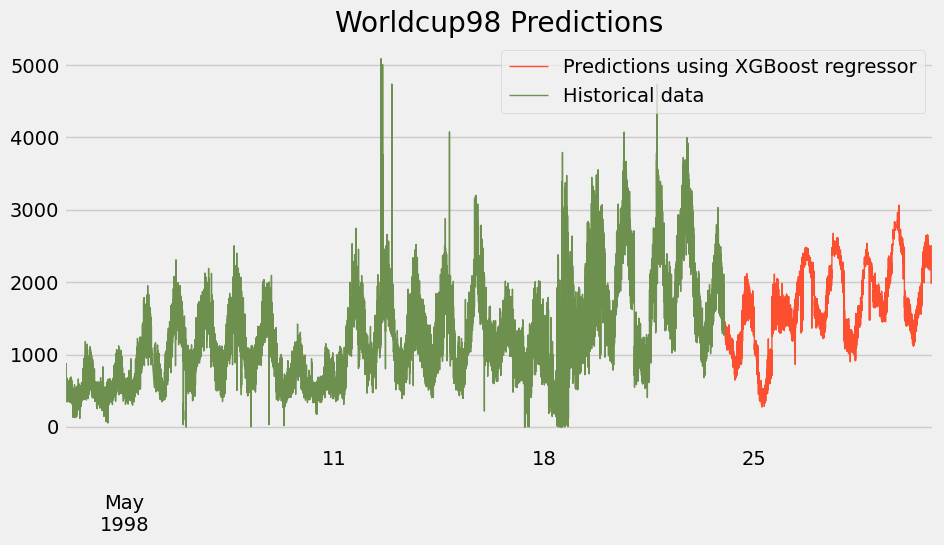

In [266]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1,
                               title='Worldcup98 Predictions')

df_and_future['total_load'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,)
plt.legend(['Predictions using XGBoost regressor','Historical data'])

plt.show()

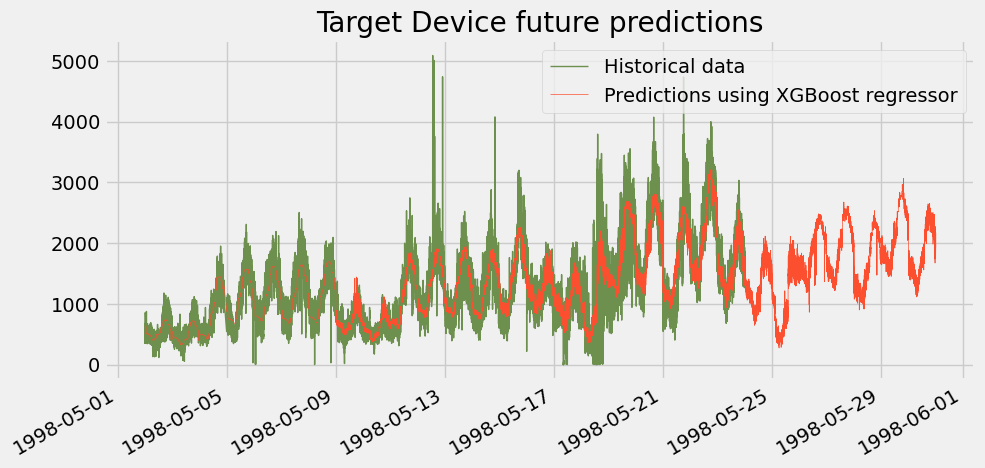

In [277]:
df_and_future['pred'] = reg.predict(df_and_future[FEATURES])


df_and_future['total_load'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,)
df_and_future['pred'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=0.5,
                               lw=0.5,
                               title='Target Device future predictions')
ax.
plt.legend(['Historical data','Predictions using XGBoost regressor'])

plt.show()


# Här kommer kod sen innan! Allt ovanför följer youtube tutorialom XGBoost

In [200]:
#Small effort do delete outliers
# calculate summary statistics
data_mean, data_std = mean(historical_df["total_load"]), std(historical_df["total_load"])
cut_off = data_std * 1 #Räknas som outliers om de är mer än 2 standard deviations från medelvärdet. 
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower,upper)
print(data_mean)

outliers = [x for x in historical_df["total_load"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
...
outliers_removed = [x for x in historical_df["total_load"] if x > lower and x < upper]
print(len(outliers_removed))
historical_df_outliers_removed = historical_df[(historical_df["total_load"] > lower) & (historical_df["total_load"] < upper)]


179.79130785156258 1930.7323596847773
1055.26183376817
Identified outliers: 1017
20447


In [248]:
X = historical_df['timestamp'].astype(int).values.reshape(-1, 1)
y = historical_df['total_load'].values.reshape(-1, 1)
print(X,y)

[[894067200000000000]
 [894067260000000000]
 [894067320000000000]
 ...
 [895363020000000000]
 [895363080000000000]
 [895363140000000000]] [[ 352]
 [ 373]
 [ 401]
 ...
 [ 957]
 [1252]
 [ 987]]


In [85]:
##Scale the data. This part doesnt work as expected.

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
print(X,y)

[[-1.73557606]
 [-1.73535727]
 [-1.73513848]
 ...
 [ 1.72934782]
 [ 1.7295666 ]
 [ 1.72978539]] [[-1.27776128]
 [-1.23208847]
 [-1.17119138]
 ...
 [ 0.89713476]
 [ 0.75794141]
 [ 0.29468856]]


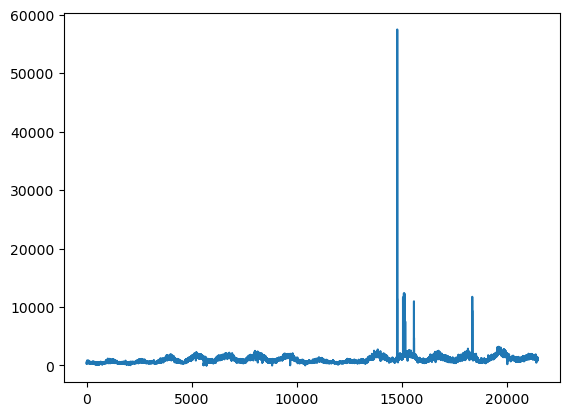

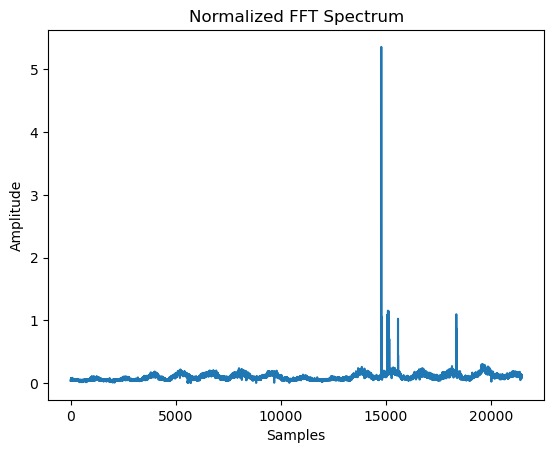

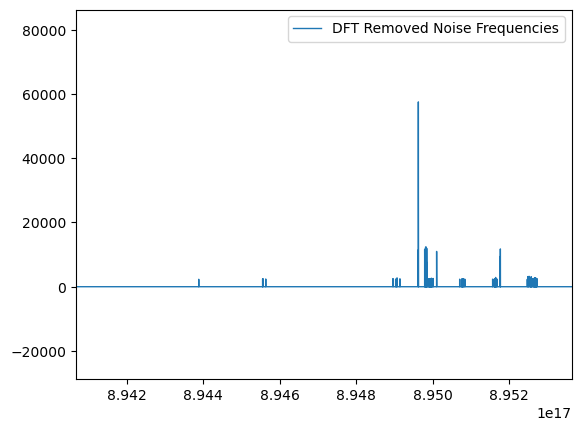

In [250]:
##Fourier aproximation FUNKAR EJ
# Apply the FFT on the signal
fourier = fft(y)

# Plot the result (the spectrum |Xk|)
plt.plot(np.abs(fourier))
plt.show()

N = len(y)
normalize = N/2

# Plot the normalized FFT (|Xk|)/(N/2)
plt.plot(np.abs(fourier)/normalize)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Normalized FFT Spectrum')
plt.show()

yf_abs      = np.abs(y) 
indices     = yf_abs>2300   # filter out those value under 300
yfClean    = indices * y # noise frequency will be set to 0
plt.plot(X,np.abs(yfClean),linewidth=1,label="DFT Removed Noise Frequencies")
plt.margins(x=0, y=0.5)
plt.legend()
plt.show()


In [223]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=(0.2/0.9), random_state=42) #Taget från intelligenta

In [204]:
# Model Evaluation
##Linear regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 151212.3521888552


In [32]:
#Support vector machines
# Train SVR model with polynomial kernel
poly_svr = make_pipeline(StandardScaler(), SVR(kernel='poly', degree=5, C=100, gamma="auto", epsilon=0.1, coef0=1))  # Adjust degree as needed
poly_svr.fit(X_train, y_train)
# Predict workload
y_pred = poly_svr.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 132627.36284775936


In [67]:

# Initialize variables to store best degree and corresponding MSE
best_degree = None
best_mse = float('inf')  # Initialize with a large value

# Try different degrees
for degree in range(1, 6):  # Try degrees 1 to 5
    # Train SVR model with polynomial kernel
    poly_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', degree=degree))
    poly_svr.fit(X_train, y_train)

    # Predict workload on validation set
    y_pred = poly_svr.predict(X_val)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)

    # Check if current degree gives lower MSE
    if mse < best_mse:
        best_mse = mse
        best_degree = degree

# Print the best degree and corresponding MSE
print("Best Degree:", best_degree)
print("Best MSE:", best_mse)

Best Degree: 1
Best MSE: 141895.00995225305


In [225]:
## Trying SVM with regression 
svr = SVR(C=1.0, epsilon=0.2).fit(X_train, y_train)
# Predict workload
y_pred = svr.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
score = svr.score(X,y)
print("R-squared:", score)


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 188461.48591859464


ValueError: X has 1 features, but SVR is expecting 100 features as input.

SVR()


In [139]:
## Decision Tree
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_tree)
print("Mean Squared Error:", mse)


Mean Squared Error: 22814.734977139124


In [140]:
## Random Forests
forest_model = RandomForestRegressor(max_depth= 10,min_samples_leaf = 1, min_samples_split = 10, n_estimators = 300)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_forest)
print("Mean Squared Error:", mse)

/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 22569.017421441826


In [ ]:
# parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],        # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required to be at a leaf node
}

forest_model = RandomForestRegressor()

grid_search = GridSearchCV(forest_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_forest_model = grid_search.best_estimator_
y_pred_forest = best_forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_forest)
print("Mean Squared Error:", mse)

print("Best Parameters:", grid_search.best_params_)

Mean Squared Error: 183.56072563159594
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [138]:

## Gradient Boosting
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_gbm)
print("Mean Squared Error:", mse)

/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Mean Squared Error: 24500.401071219083


In [112]:
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)
y_pred = knn_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
hyperparameters = {'n_neighbors': np.arange(1,30,1)}


Mean Squared Error: 16951.350847337446


In [219]:
last_date = historical_df_outliers_removed['timestamp'].max()
first_date = historical_df_outliers_removed['timestamp'].min()
next_day = last_date + pd.DateOffset(days=1)

#Prepare next day timestamps, starting from the beginning of the next day 
next_day_timestamps = pd.date_range(start=next_day.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
all_days= pd.date_range(start=first_date.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
print(next_day_timestamps)
print(all_days)

DatetimeIndex(['1998-05-17 00:00:00', '1998-05-17 00:01:00',
               '1998-05-17 00:02:00', '1998-05-17 00:03:00',
               '1998-05-17 00:04:00', '1998-05-17 00:05:00',
               '1998-05-17 00:06:00', '1998-05-17 00:07:00',
               '1998-05-17 00:08:00', '1998-05-17 00:09:00',
               ...
               '1998-05-18 23:50:00', '1998-05-18 23:51:00',
               '1998-05-18 23:52:00', '1998-05-18 23:53:00',
               '1998-05-18 23:54:00', '1998-05-18 23:55:00',
               '1998-05-18 23:56:00', '1998-05-18 23:57:00',
               '1998-05-18 23:58:00', '1998-05-18 23:59:00'],
              dtype='datetime64[ns]', length=2880, freq='T')
DatetimeIndex(['1998-05-02 00:00:00', '1998-05-02 00:01:00',
               '1998-05-02 00:02:00', '1998-05-02 00:03:00',
               '1998-05-02 00:04:00', '1998-05-02 00:05:00',
               '1998-05-02 00:06:00', '1998-05-02 00:07:00',
               '1998-05-02 00:08:00', '1998-05-02 00:09:00',
    

In [220]:
next_day_predictions = model.predict(next_day_timestamps.astype(int).values.reshape(-1, 1))  # Use your model to predict workload for next_day_timestamps
all_day_predictions = svr.predict(all_days.astype(int).values.reshape(-1, 1))
print(all_day_predictions)


[ 473.70145474  473.72024949  473.73908263 ... 1036.21991117 1036.17872824
 1036.13754962]


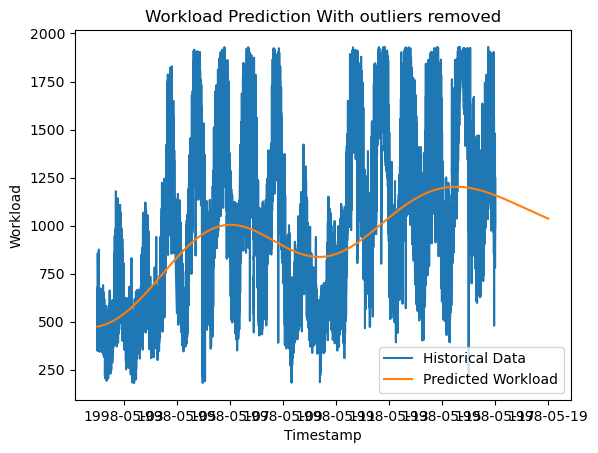

In [221]:
plt.plot(historical_df_outliers_removed['timestamp'], historical_df_outliers_removed['total_load'], label='Historical Data')

plt.plot(all_days, all_day_predictions, label='Predicted Workload')
plt.xlabel('Timestamp')
plt.ylabel('Workload')
plt.title('Workload Prediction With outliers removed')
plt.legend()
plt.show()

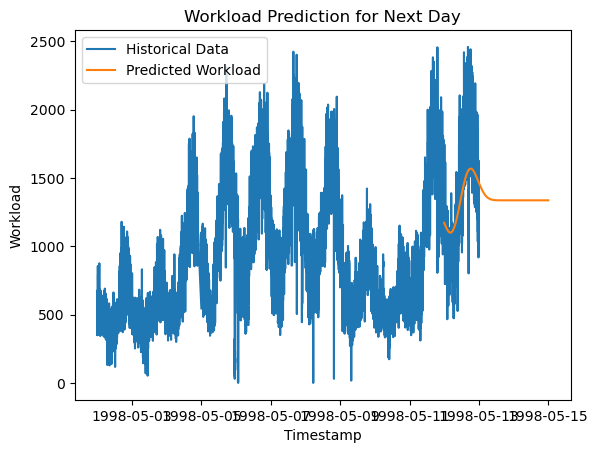

In [27]:
five_fays = first_date + pd.DateOffset(days=10)
last_five_days= pd.date_range(start=five_fays.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
last_five_days_predictions = svr.predict(last_five_days.astype(int).values.reshape(-1, 1))

plt.plot(historical_df['timestamp'], historical_df['total_load'], label='Historical Data')

plt.plot(last_five_days, last_five_days_predictions, label='Predicted Workload')
plt.xlabel('Timestamp')
plt.ylabel('Workload')
plt.title('Workload Prediction for Next Day')
plt.legend()
plt.show()